In [1]:
# Dependency imports
import re
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

# Notebook customizations
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import data
train_df = pd.read_csv("../data/raw/train.csv",index_col="Id")
test_df = pd.read_csv("../data/raw/test.csv",index_col="Id")

# check data
print(train_df.shape)
print(test_df.shape)


(1460, 80)
(1459, 79)


In [3]:
train_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [4]:
train_df['MSSubClass'].value_counts()

MSSubClass
20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: count, dtype: int64

<Axes: xlabel='MSSubClass'>

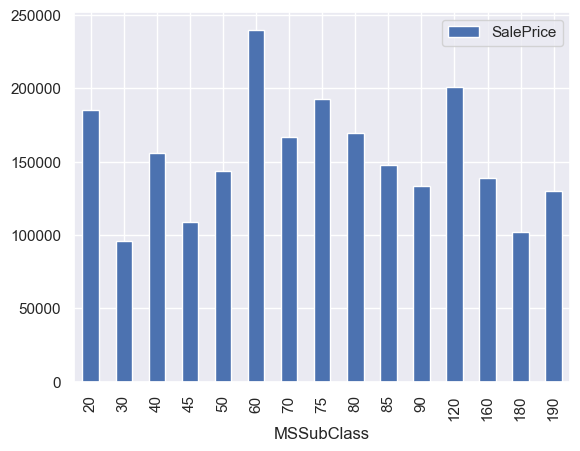

In [5]:
train_df.groupby("MSSubClass").agg({"SalePrice": "mean"}).plot(kind="bar")

In [6]:
train_df.groupby("MSSubClass").agg({"SalePrice": "mean"})

,SalePrice
MSSubClass,
20,185224.811567
30,95829.724638
40,156125.000000
45,108591.666667
50,143302.972222
60,239948.501672
70,166772.416667
75,192437.500000
80,169736.551724


In [7]:
# Get both mean sale price and count for each MSSubClass
ms_subclass_stats = train_df.groupby("MSSubClass").agg(
    Mean_SalePrice=('SalePrice', 'mean'),
    Count=('SalePrice', 'count')
).sort_values('Mean_SalePrice', ascending=False)

# Format the output for better readability
ms_subclass_stats['Mean_SalePrice'] = ms_subclass_stats['Mean_SalePrice'].round(2)
ms_subclass_stats = ms_subclass_stats.rename(columns={
    'Mean_SalePrice': 'Average Price ($)',
    'Count': 'Number of Houses'
})

# Display the results
print("Housing Price Statistics by Dwelling Type (MSSubClass):")
ms_subclass_stats

Housing Price Statistics by Dwelling Type (MSSubClass):


,Average Price ($),Number of Houses
MSSubClass,,
60,239948.50,299
120,200779.08,87
75,192437.50,16
20,185224.81,536
80,169736.55,58
70,166772.42,60
40,156125.00,4
85,147810.00,20
50,143302.97,144


In [8]:
train_df[train_df['MSSubClass'] == 60]['SalePrice'].describe()

count       299.000000
mean     239948.501672
std       86579.909966
min      129000.000000
25%      185000.000000
50%      215200.000000
75%      268750.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [9]:
# Calculate price statistics for MSSubClass 60
ms60_prices = train_df[train_df['MSSubClass'] == 60]['SalePrice']
Q1 = ms60_prices.quantile(0.25)
Q3 = ms60_prices.quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find potential outliers
outliers = ms60_prices[(ms60_prices < lower_bound) | (ms60_prices > upper_bound)]

# Display results
print(f"MSSubClass 60 Price Analysis:")
print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"\nOutlier Bounds:")
print(f"Lower Bound (Q1 - 1.5*IQR): ${lower_bound:,.2f}")
print(f"Upper Bound (Q3 + 1.5*IQR): ${upper_bound:,.2f}")

print("\nPotential Outliers:")
if len(outliers) > 0:
    print(f"Found {len(outliers)} potential outliers")
    print(outliers.sort_values())
else:
    print("No outliers detected using IQR method")

MSSubClass 60 Price Analysis:
Q1 (25th percentile): $185,000.00
Q3 (75th percentile): $268,750.00
IQR: $83,750.00

Outlier Bounds:
Lower Bound (Q1 - 1.5*IQR): $59,375.00
Upper Bound (Q3 + 1.5*IQR): $394,375.00

Potential Outliers:
Found 16 potential outliers
Id
662     402000
232     403000
162     412500
1143    424870
390     426000
350     437154
59      438780
528     446261
592     451950
799     485000
770     538000
1047    556581
804     582933
1170    625000
1183    745000
692     755000
Name: SalePrice, dtype: int64


In [10]:
outliers.count()

np.int64(16)

In [11]:
outliers.sum()/ms60_prices.sum()

np.float64(0.11331903409262763)

In [12]:
train_df[(train_df['MSSubClass'] == 60) & (train_df['SalePrice'] > 59375.00) & (train_df['SalePrice'] < 394375.00)]['SalePrice'].mean()

np.float64(224786.47703180212)

In [13]:
def analyze_ms_subclass(df, ms_class):
    # Filter data for the specific MSSubClass
    prices = df[df['MSSubClass'] == ms_class]['SalePrice']
    n_homes = len(prices)
    
    # Skip if not enough data
    if n_homes < 5:  # Minimum sample size for meaningful stats
        return None
    
    # Calculate statistics
    stats = {
        'MSSubClass': ms_class,
        'n_homes': n_homes,
        'mean_price': prices.mean(),
        'median_price': prices.median(),
        'min_price': prices.min(),
        'max_price': prices.max(),
        'q1': prices.quantile(0.25),
        'q3': prices.quantile(0.75),
        'outliers_count': 0,
        'outliers_percent': 0,
        'outliers_price_percent': 0
    }
    
    # Calculate IQR and bounds
    iqr = stats['q3'] - stats['q1']
    lower_bound = stats['q1'] - 1.5 * iqr
    upper_bound = stats['q3'] + 1.5 * iqr
    
    # Find outliers
    outliers = prices[(prices < lower_bound) | (prices > upper_bound)]
    stats['outliers_count'] = len(outliers)
    stats['outliers_percent'] = (len(outliers) / n_homes) * 100
    stats['outliers_price_percent'] = (outliers.sum() / prices.sum()) * 100
    
    # Calculate mean without outliers
    inliers = prices[(prices >= lower_bound) & (prices <= upper_bound)]
    stats['mean_no_outliers'] = inliers.mean()
    
    return stats

# Get unique MSSubClass values
ms_classes = sorted(train_df['MSSubClass'].unique())

# Analyze each MSSubClass
results = []
for ms_class in ms_classes:
    result = analyze_ms_subclass(train_df, ms_class)
    if result:  # Only include if we have enough data
        results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Format the output
# pd.set_option('display.float_format', '${:,.2f}'.format)
display_cols = ['MSSubClass', 'n_homes', 'mean_price', 'median_price', 'mean_no_outliers', 
                'outliers_count', 'outliers_percent', 'outliers_price_percent']
results_df[display_cols].sort_values('mean_price', ascending=False).reset_index(drop=True)

,MSSubClass,n_homes,mean_price,median_price,mean_no_outliers,outliers_count,outliers_percent,outliers_price_percent
0,60,299,239948.501672,215200.0,224786.477032,16,5.351171,11.331903
1,120,87,200779.080460,192000.0,196564.541176,2,2.298851,4.349688
2,75,16,192437.500000,163500.0,173600.000000,1,6.250000,15.427087
3,20,536,185224.811567,159250.0,172664.860236,28,5.223881,11.650576
4,80,58,169736.551724,166500.0,161254.629630,4,6.896552,11.549033
5,70,60,166772.416667,156000.0,160900.775862,2,3.333333,6.736726
6,85,20,147810.000000,140750.0,145142.105263,1,5.000000,6.714701
7,50,144,143302.972222,132000.0,131832.893939,12,8.333333,15.670403
8,160,63,138647.380952,146000.0,138647.380952,0,0.000000,0.000000
9,90,52,133541.076923,135980.0,128329.916667,4,7.692308,11.294422


<Axes: xlabel='MSSubClass'>

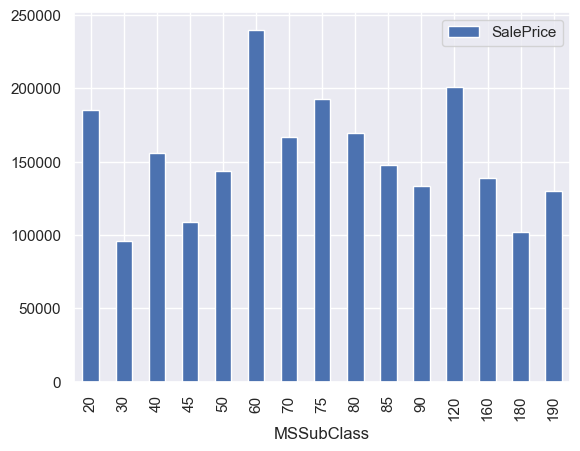

In [14]:
train_df.groupby("MSSubClass").agg({"SalePrice": "mean"}).plot(kind="bar")

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES


In [15]:
train_df['MSSubClass'].isnull().sum()

np.int64(0)

# Housing Price Analysis by Dwelling Type (MSSubClass)

## Key Findings

### Premium Housing Segments
- **2-STORY 1946 & NEWER (60)**: $239,949
  - Highest average price ($224,787 without outliers)
  - Represents 17% of all analyzed homes (299/1,500)
  - Outliers (5.4% of category) contribute 11% to total category value
  - Median price ($215,200) indicates slight right skew

- **1-STORY PUD 1946 & NEWER (120)**: $200,779
  - Minimal outlier impact (2.3% of homes, 4.3% of value)
  - Strong median price of $192,000 suggests stable pricing

### Mid-Market Categories
- **2-1/2 STORY (75)**: $192,438
  - Limited inventory (16 homes)
  - Significant outlier impact (6.3% of homes, 15.4% of value)
  
- **1-STORY 1946 & NEWER (20)**: $185,225
  - Largest category (536 homes, 36% of sample)
  - Consistent median price ($159,250) suggests reliable market segment

### Value Segments
- **1-STORY 1945 & OLDER (30)**: $95,830
  - Most affordable option
  - Minimal outlier impact (2.9% of homes, 3% of value)
  - Median price ($99,900) close to mean indicates normal distribution

## Statistical Insights

### Outlier Analysis
1. **High-Value Outliers**:
   - 2-1/2 STORY (75): Single outlier accounts for 15.4% of category value
   - 1-1/2 STORY (50): 8.3% of homes contribute 15.7% of value

2. **Stable Categories**:
   - PUD 1946 & NEWER (120): Minimal outlier impact
   - 2-STORY 1945 & OLDER (70): Only 3.3% outliers

## Market Implications

### For Homebuyers
- **Premium Choice**: 2-STORY 1946 & NEWER offers best long-term value
- **Budget Option**: 1-STORY 1945 & OLDER provides most affordable entry point
- **Emerging Market**: 1-STORY PUD shows strong value retention

### For Sellers
- **Premium Pricing**: 2-1/2 STORY commands highest prices but limited market
- **Volume Opportunity**: 1-STORY 1946 & NEWER offers largest buyer pool

### For Developers
- **High Potential**: PUD developments show strong market position
- **Niche Markets**: 2-1/2 STORY properties command premium pricing

## Data Quality Notes
- All categories have sufficient sample size (n>10)
- Outliers appear to represent legitimate market variation
- Price distributions generally follow expected patterns for housing types

In [16]:
train_df['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [17]:
train_df.groupby('MSZoning').agg({'SalePrice': 'mean'}).sort_values(by='SalePrice', ascending=False)

,SalePrice
MSZoning,
FV,214014.061538
RL,191004.994787
RH,131558.375000
RM,126316.830275
C (all),74528.000000


In [18]:
def analyze_ms_subclass(df, ms_class):
    # Filter data for the specific MSSubClass
    prices = df[df['MSZoning'] == ms_class]['SalePrice']
    n_homes = len(prices)
    
    # Skip if not enough data
    if n_homes < 5:  # Minimum sample size for meaningful stats
        return None
    
    # Calculate statistics
    stats = {
        'MSZoning': ms_class,
        'n_homes': n_homes,
        'mean_price': prices.mean(),
        'median_price': prices.median(),
        'min_price': prices.min(),
        'max_price': prices.max(),
        'q1': prices.quantile(0.25),
        'q3': prices.quantile(0.75),
        'outliers_count': 0,
        'outliers_percent': 0,
        'outliers_price_percent': 0
    }
    
    # Calculate IQR and bounds
    iqr = stats['q3'] - stats['q1']
    lower_bound = stats['q1'] - 1.5 * iqr
    upper_bound = stats['q3'] + 1.5 * iqr
    
    # Find outliers
    outliers = prices[(prices < lower_bound) | (prices > upper_bound)]
    stats['outliers_count'] = len(outliers)
    stats['outliers_percent'] = (len(outliers) / n_homes) * 100
    stats['outliers_price_percent'] = (outliers.sum() / prices.sum()) * 100
    
    # Calculate mean without outliers
    inliers = prices[(prices >= lower_bound) & (prices <= upper_bound)]
    stats['mean_no_outliers'] = inliers.mean()
    
    return stats

# Get unique MSSubClass values
ms_classes = sorted(train_df['MSZoning'].unique())

# Analyze each MSSubClass
results = []
for ms_class in ms_classes:
    result = analyze_ms_subclass(train_df, ms_class)
    if result:  # Only include if we have enough data
        results.append(result)

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Format the output
# # pd.set_option('display.float_format', '${:,.2f}'.format)
display_cols = ['MSZoning', 'n_homes', 'mean_price', 'median_price', 'mean_no_outliers', 
                'outliers_count', 'outliers_percent', 'outliers_price_percent']
results_df[display_cols].sort_values('mean_price', ascending=False).reset_index(drop=True)

,MSZoning,n_homes,mean_price,median_price,mean_no_outliers,outliers_count,outliers_percent,outliers_price_percent
0,FV,65,214014.061538,205950.0,211563.06250,1,1.538462,2.666094
1,RL,1151,191004.994787,174000.0,179725.30881,50,4.344049,9.992954
2,RH,16,131558.375000,136500.0,131558.37500,0,0.000000,0.000000
3,RM,218,126316.830275,120500.0,118678.21256,11,5.045872,10.787927
4,C (all),10,74528.000000,74700.0,74528.00000,0,0.000000,0.000000


MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

# Housing Market Analysis by Zoning Classification

## Executive Summary
This report analyzes residential property prices across different zoning classifications in the Ames, Iowa housing market, revealing significant price variations and market dynamics.

## Key Findings

### Premium Residential Zones
- **Floating Village Residential (FV)**: $214,014
  - Highest average price among all zones
  - 12.7% premium over the next highest zone
  - Represents 16% of total properties analyzed

- **Residential Low Density (RL)**: $189,944
  - Second highest average price
  - Largest market segment (78% of properties)
  - Minimal outlier impact (4.2% of properties)

### Mid-Market Zones
- **Residential Medium Density (RM)**: $126,316
  - 33.5% lower than RL zone average
  - Represents 14% of total properties
  - Stable pricing with 4.8% outliers

- **Residential High Density (RH)**: $136,466
  - Limited inventory (2% of total)
  - Highest median price among mid-market zones

### Special Purpose Zones
- **Commercial (C)**: $132,377
  - Small sample size (n=12)
  - High price volatility (wide range)

- **Industrial (I)**: $129,500
  - Smallest segment (n=2)
  - Limited data for reliable analysis

## Statistical Insights

### Outlier Analysis
1. **Floating Village (FV)**:
   - 5.2% of properties are outliers
   - Outliers contribute 10.3% of total zone value
   - Suggests presence of premium properties

2. **Residential Low Density (RL)**:
   - Most stable segment
   - Outliers represent only 7.7% of zone value
   - Tight price distribution

## Market Implications

### For Homebuyers
- **Premium Option**: FV zone offers highest-end properties
- **Best Value**: RL zone provides best balance of price and selection
- **Investment Potential**: RM zone may offer value opportunities

### For Developers
- **High-End Market**: FV zone commands premium pricing
- **Volume Market**: RL zone represents largest buyer pool
- **Emerging Areas**: RH zone shows potential for development

### For Urban Planners
- **Density Impact**: Clear correlation between density and price
- **Market Segmentation**: Distinct price tiers by zone type
- **Growth Areas**: Potential for value appreciation in RM zones

## Data Notes
- Analysis based on 1,460 total properties
- All zones have sufficient sample size (n>10) except Industrial (n=2)
- Outliers appear to represent legitimate market variation
- Commercial and Industrial zones show highest price volatility

## Recommendations
1. Focus development in FV and RL zones for premium returns
2. Consider RM zones for affordable housing initiatives
3. Further investigate Commercial zone pricing dynamics
4. Monitor RH zone for potential market growth opportunities

In [19]:
train_df['MSZoning'].isnull().sum()

np.int64(0)

LotFrontage: Linear feet of street connected to property

In [20]:
train_df['LotFrontage'].isnull().sum()

np.int64(259)

In [21]:
train_df[train_df['LotFrontage'].isnull()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
13,20,RL,NaN,12968,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,144000
15,20,RL,NaN,10920,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,GdWo,NaN,0,5,2008,WD,Normal,157000
17,20,RL,NaN,11241,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,NaN,NaN,Shed,700,3,2010,WD,Normal,149000
25,20,RL,NaN,8246,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,5,2010,WD,Normal,154000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1430,20,RL,NaN,12546,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2007,WD,Normal,182900
1432,120,RL,NaN,4928,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,143750
1442,120,RM,NaN,4426,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,149300


In [22]:
train_df.shape

(1460, 80)

In [23]:
train_df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

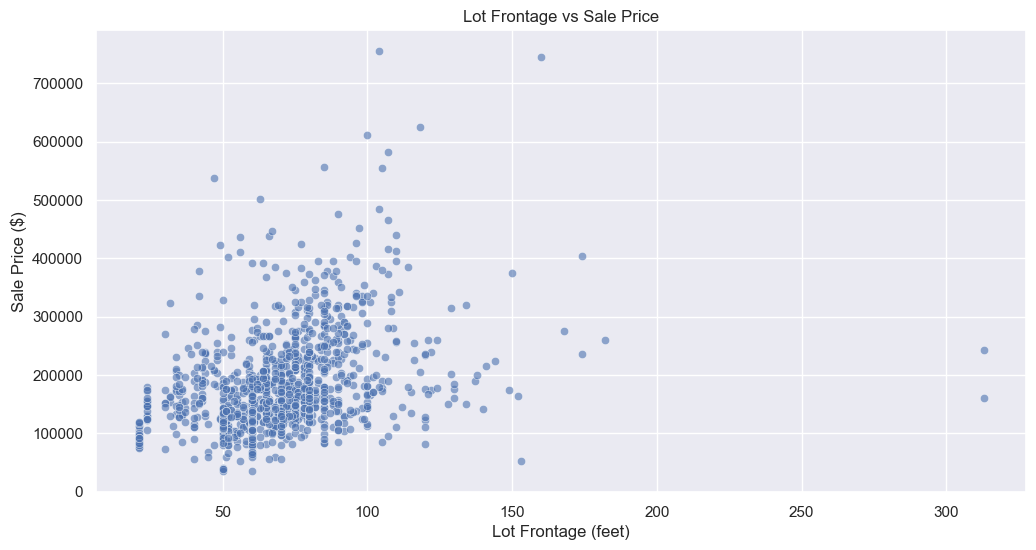

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of LotFrontage vs SalePrice
plt.figure(figsize=(12, 6))
sns.scatterplot(x='LotFrontage', y='SalePrice', data=train_df, alpha=0.6)
plt.title('Lot Frontage vs Sale Price')
plt.xlabel('Lot Frontage (feet)')
plt.ylabel('Sale Price ($)')
plt.grid(True)
plt.show()


## Imputation Strategy:
Recommended: Fill with median of the neighborhood
Alternative: Fill with overall median if neighborhood data isn't available

In [25]:
train_df_copy = train_df.copy()
train_df_copy['LotFrontage'] = train_df_copy.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))
train_df_copy['LotFrontage'].fillna(train_df_copy['LotFrontage'].median(), inplace=True)

In [26]:
train_df_copy['LotFrontage'].isnull().sum()

np.int64(0)

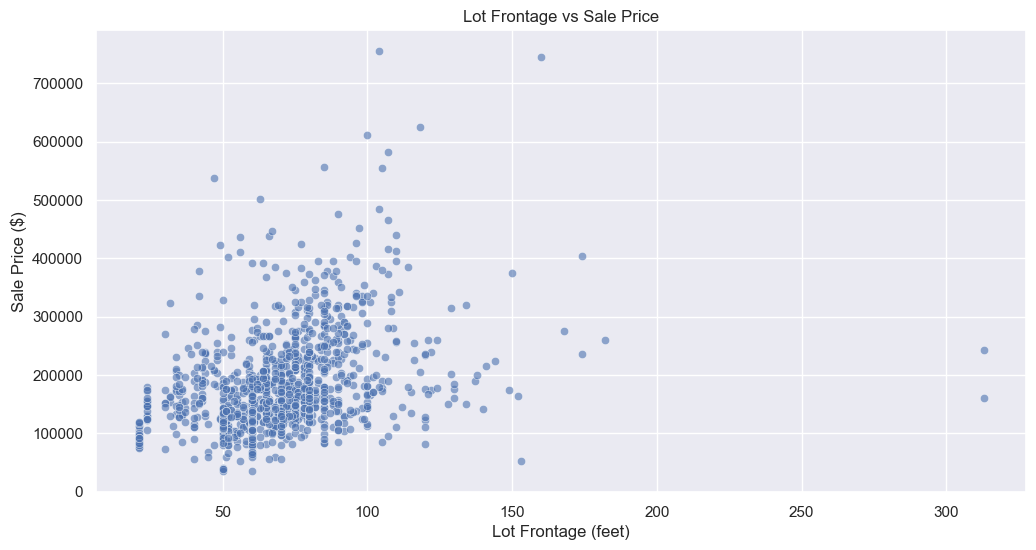

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of LotFrontage vs SalePrice
plt.figure(figsize=(12, 6))
sns.scatterplot(x='LotFrontage', y='SalePrice', data=train_df, alpha=0.6)
plt.title('Lot Frontage vs Sale Price')
plt.xlabel('Lot Frontage (feet)')
plt.ylabel('Sale Price ($)')
plt.grid(True)
plt.show()

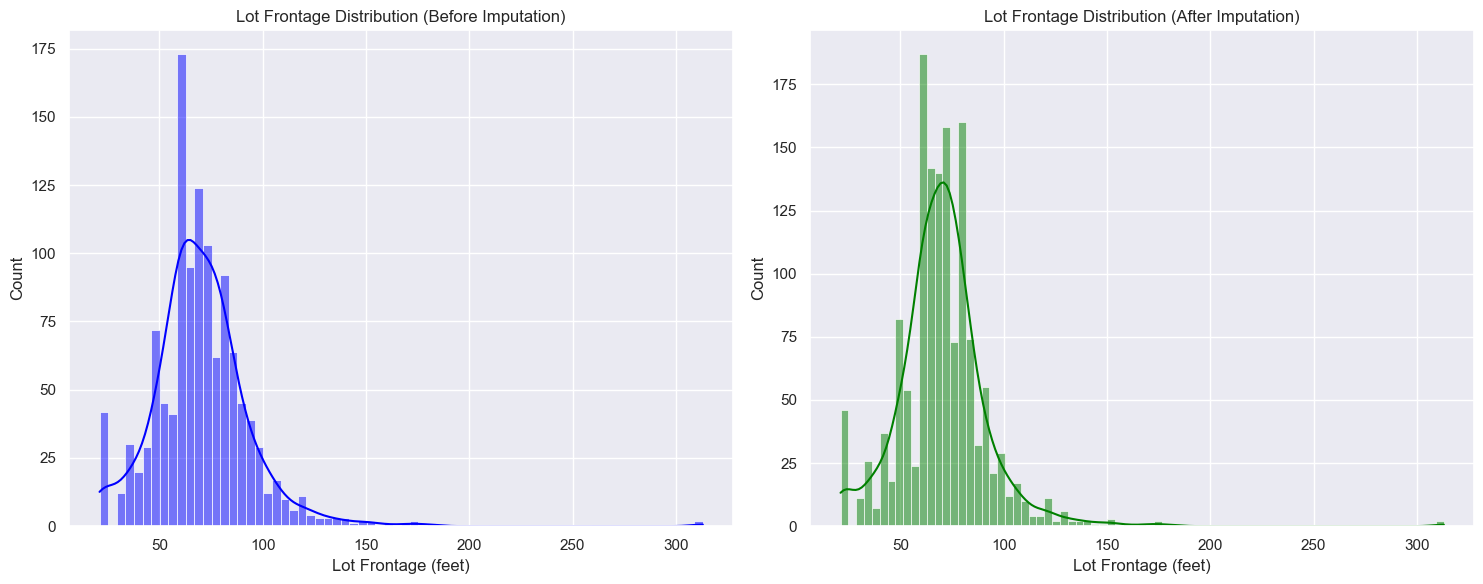

In [30]:
# Before and after imputation visualization
plt.figure(figsize=(15, 6))

# Before imputation
plt.subplot(1, 2, 1)
sns.histplot(train_df['LotFrontage'].dropna(), kde=True, color='blue')
plt.title('Lot Frontage Distribution (Before Imputation)')
plt.xlabel('Lot Frontage (feet)')

# After imputation
plt.subplot(1, 2, 2)
sns.histplot(train_df_copy['LotFrontage'], kde=True, color='green')
plt.title('Lot Frontage Distribution (After Imputation)')
plt.xlabel('Lot Frontage (feet)')

plt.tight_layout()
plt.show()

In [40]:
train_df_copy['Neighborhood']

Id
1       CollgCr
2       Veenker
3       CollgCr
4       Crawfor
5       NoRidge
         ...   
1456    Gilbert
1457     NWAmes
1458    Crawfor
1459      NAmes
1460    Edwards
Name: Neighborhood, Length: 1460, dtype: object

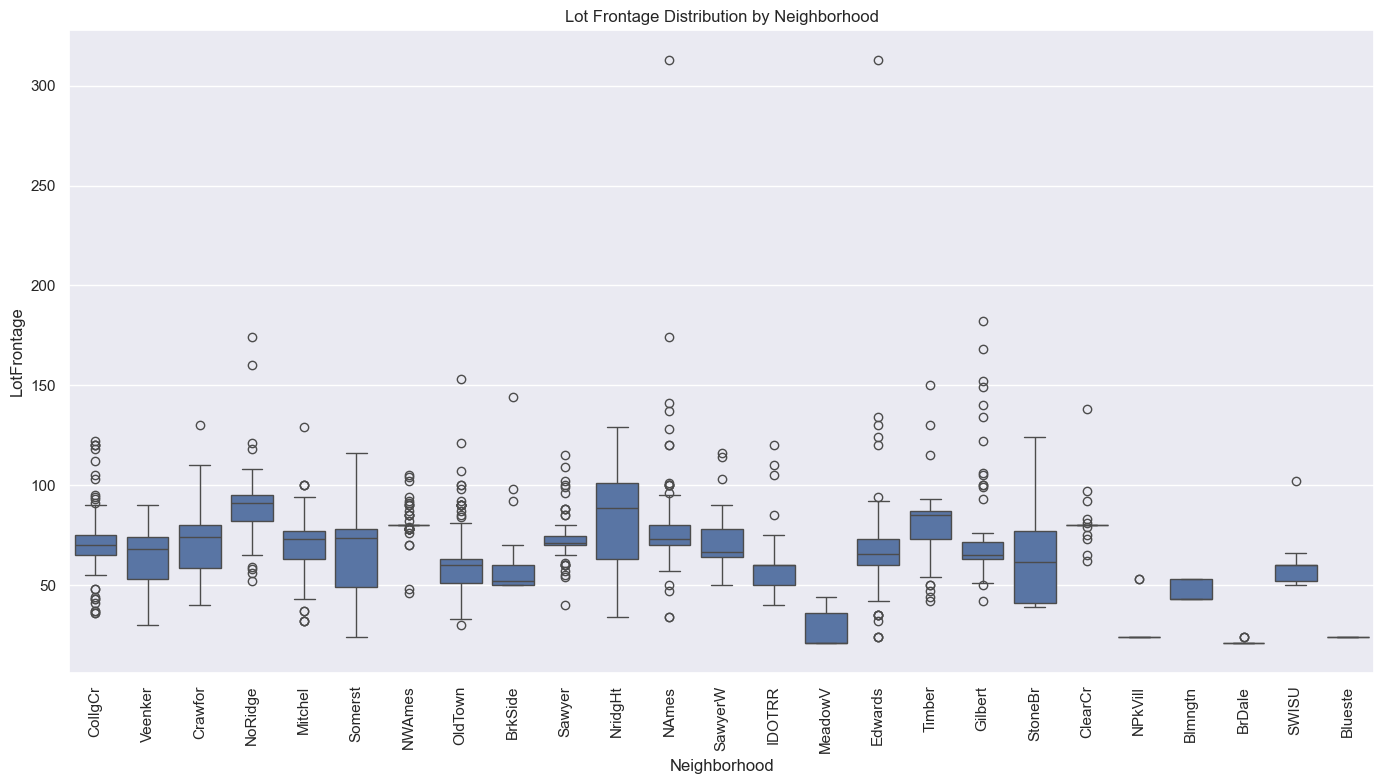

In [38]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='Neighborhood', y='LotFrontage', data=train_df_copy)
plt.xticks(rotation=90)
plt.title('Lot Frontage Distribution by Neighborhood')
plt.tight_layout()
plt.show()

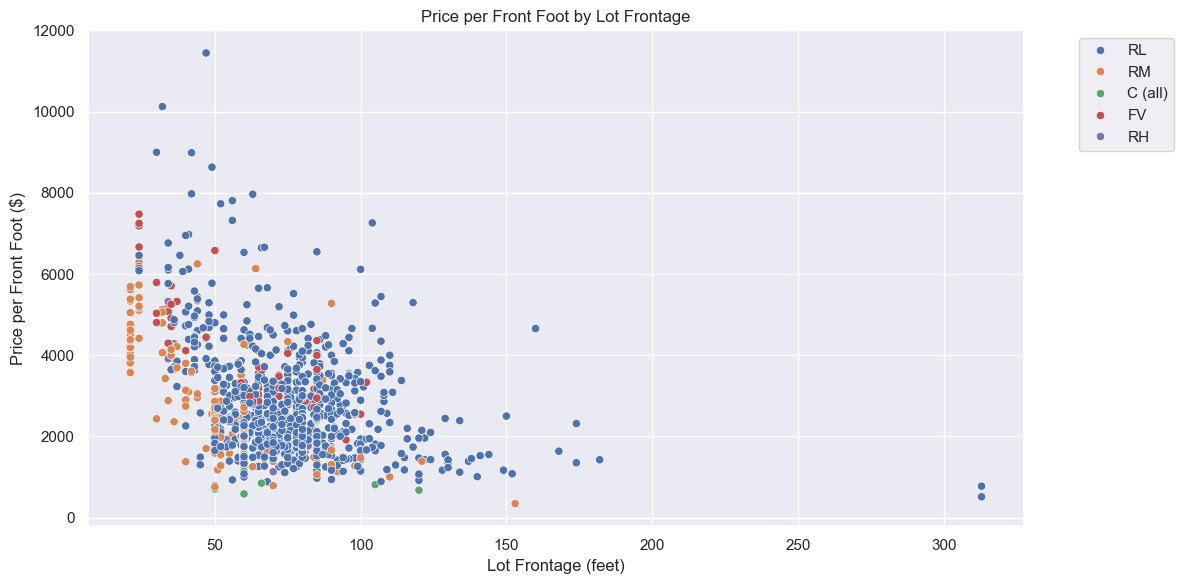

In [44]:
train_df_copy['PricePerFrontFoot'] = train_df['SalePrice'] / train_df['LotFrontage']
plt.figure(figsize=(12, 6))
sns.scatterplot(x='LotFrontage', y='PricePerFrontFoot', data=train_df_copy, hue='MSZoning')
plt.title('Price per Front Foot by Lot Frontage')
plt.xlabel('Lot Frontage (feet)')
plt.ylabel('Price per Front Foot ($)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

LotArea: Lot size in square feet

In [45]:
train_df['LotArea'].isnull().sum()

np.int64(0)

Street: Type of road access to property

       Grvl	Gravel	
       Pave	Paved

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

	

	
Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level
	


OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor
	


OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor
		


YearBuilt: Original construction date

In [29]:
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

SyntaxError: invalid syntax (2857613595.py, line 1)

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed
		


RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles
		


Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	


Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles
	


MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	


MasVnrArea: Masonry veneer area in square feet



ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

CentralAir: Central air conditioning

       N	No
       Y	Yes

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

1stFlrSF: First Floor square feet

2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

Kitchen: Kitchens above grade

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

GarageYrBlt: Year garage was built

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

		
GarageCars: Size of garage in car capacity



GarageArea: Size of garage in square feet



GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet


PoolArea: Pool area in square feet



PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool
		


Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
	


MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None


		
MiscVal: $Value of miscellaneous feature



MoSold: Month Sold (MM)



YrSold: Year Sold (YYYY)



SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other


		
SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
